# Egg-box Likelihood with Uniform Prior

This is a toy model shows how Nested Sampling easily handles likelihoods with multimodal behaviour.

$L(x) = P(y | x) = 5 (2. + \prod_i cos(\frac{\theta_i}{2})))$

and

$P(x) = \mathcal{U}[x \mid 0, 10 \pi]$.


In [3]:
import pylab as plt
import tensorflow_probability.substrates.jax as tfp
from jax import random, numpy as jnp
from jax import vmap

from jaxns import ExactNestedSampler
from jaxns import Model
from jaxns import PriorModelGen, Prior
from jaxns import TerminationCondition
from jaxns import analytic_log_evidence

tfpd = tfp.distributions

In [ ]:
def log_likelihood(theta):
    return 5. * (2. + jnp.prod(jnp.cos(0.5 * theta)))


ndim = 2


def prior_model() -> PriorModelGen:
    x = yield Prior(tfpd.Uniform(low=jnp.zeros(ndim), high=jnp.pi * 10 * jnp.ones(ndim)), name='theta')
    return x


model = Model(prior_model=prior_model,
              log_likelihood=log_likelihood)

log_Z_true = analytic_log_evidence(model=model, S=250)
print(f"True log(Z)={log_Z_true}")


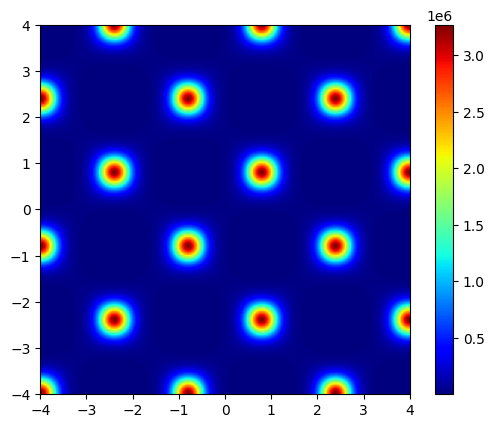

In [5]:
u_vec = jnp.linspace(0., 1., 250)
args = jnp.stack([x.flatten() for x in jnp.meshgrid(*[u_vec] * model.U_ndims, indexing='ij')], axis=-1)

# The `prepare_func_args(log_likelihood)` turns the log_likelihood into a function that nicely accepts **kwargs
lik = vmap(model.forward)(args).reshape((u_vec.size, u_vec.size))

plt.imshow(jnp.exp(lik), origin='lower', extent=(-4, 4, -4, 4), cmap='jet')
plt.colorbar()
plt.show()

In [6]:


# Create the nested sampler class. In this case without any tuning.
ns = exact_ns = ExactNestedSampler(model=model, num_live_points=200, num_parallel_samplers=1,
                                   max_samples=1e4)

termination_reason, state = exact_ns(random.PRNGKey(42),
                                     term_cond=TerminationCondition(live_evidence_frac=1e-4))
results = exact_ns.to_results(state, termination_reason)


In [7]:
# We can use the summary utility to display results
exact_ns.summary(results)

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 28738
# samples: 1661
# slices: 5000.0
# slices / acceptance: 5.0
# likelihood evals / sample: 17.3
# likelihood evals / slice: 5.3
--------
logZ=12.435 +- 0.085
H=1500000.0
ESS=461
--------
theta[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
theta[0]: 14.7 +- 8.9 | 1.8 / 13.1 / 26.3 | 31.4 | 31.4
theta[1]: 15.2 +- 9.8 | 1.9 / 13.2 / 30.0 | 6.3 | 6.3
--------


WARNING[2023-03-08 16:11:03,083]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


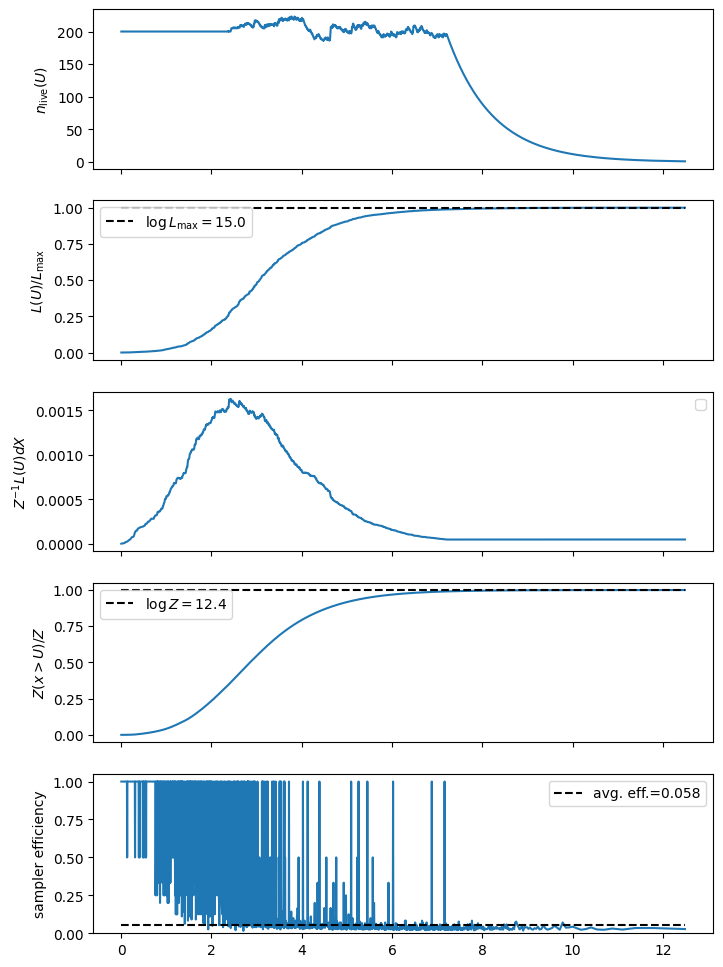

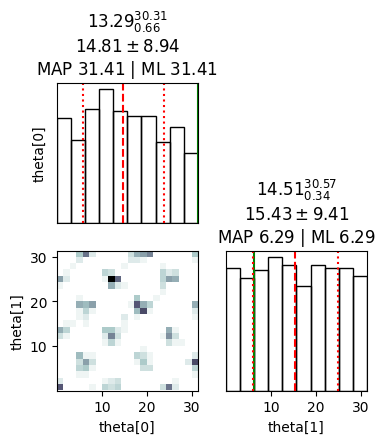

In [8]:
# We plot useful diagnostics and a distribution cornerplot
exact_ns.plot_diagnostics(results)
exact_ns.plot_cornerplot(results)